In [2]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
from ipywidgets import interact

Populating the interactive namespace from numpy and matplotlib


C:\Users\anast\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['gamma', 'beta']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


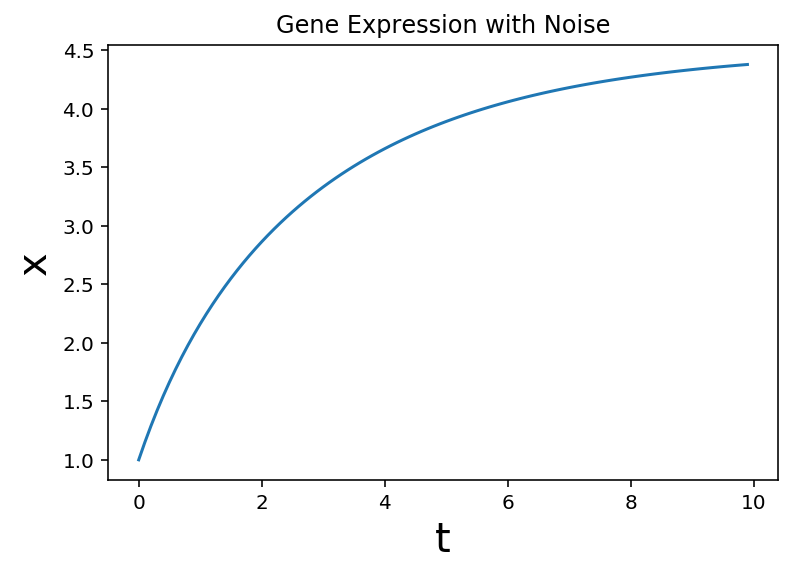

In [21]:
gamma = 2
lamda = 1
delta = 0.25 
alpha = 3.
beta = 1.
x0=1

Delta_t = 0.1
Nsteps = 100 
x = zeros(Nsteps) 
x[0] = x0 
def f_gene(x): 
    return gamma*(alpha/(alpha+(beta*(x**2))))+lamda*((beta*(x**2))/(alpha+(beta*(x**2))))-delta*x

for n in arange(1, Nsteps): 
    x[n] = x[n-1] + Delta_t*f_gene(x[n-1])

####### Plot the solution #########
t = Delta_t*arange(Nsteps) 
plot(t, x)
title("Gene Expression with Noise")
xlabel('t', fontsize=20)
ylabel('x', fontsize=20);

hello


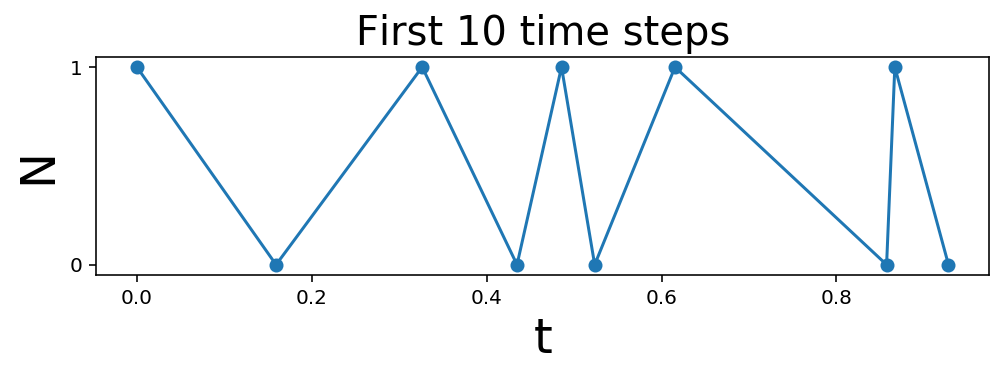

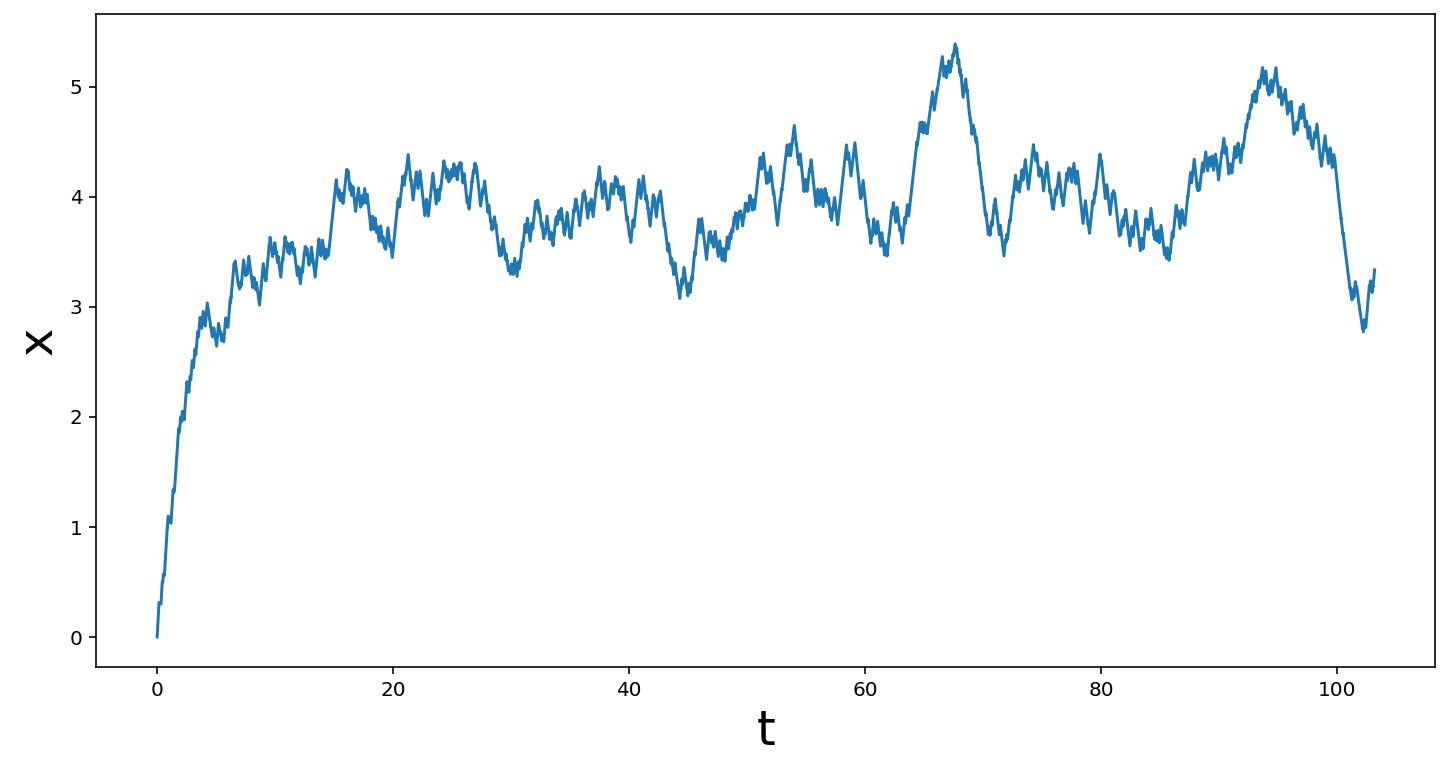

In [26]:
epsilon = 0.1
gamma = 2.
lamda = 1
delta = 0.25
alpha = 1.
beta = 1.
n0 = 0
s0 = 1
Nsteps = 1000
S = zeros(Nsteps)
S[0] = s0
N = zeros(Nsteps)
N[0] = n0
T = zeros(Nsteps)
T[0] = 0
def fullycoupledhybrid(alpha, beta, gamma, lamda, epsilon, s0, n0, Nsteps):
   
    S = zeros(Nsteps)
    S[0] = s0
    N = zeros(Nsteps)
    N[0] = n0
    T = zeros(Nsteps)
    T[0] = 0
    
    for j in arange(1, Nsteps):
        u = rand(1)[0]
        rate = beta/epsilon if S[j-1]==1 else alpha/(epsilon)
        tau = -log(u)/rate
        T[j] = T[j-1] + tau
        S[j] = 0 if S[j-1]==1 else 1
        ## update x using the exact solution above
        N[j] = N[j-1]*exp(-delta*tau) + gamma*S[j-1]/delta*(1 - exp(-delta*tau))
    return T, S, N

## I wan't to make a plot for the limiting ODE solution
Tinf = linspace(0, T[-1], 200)
Savg = alpha/(alpha + beta)
Xinf = x0*exp(-delta*Tinf) + gamma*Savg/delta*(1 - exp(-delta*Tinf))


T,S,N = fullycoupledhybrid(alpha, beta, gamma, lamda, epsilon, s0, n0, Nsteps)

figure(1, [8, 2])
plot(T[:10], S[:10], '-o')
yticks([0, 1])
title('First 10 time steps', fontsize=20)
xlabel('t', fontsize=24)
ylabel('N', fontsize=24);

figure(3, [12, 6])
plot(T, N)
#plot(Tinf, Xinf, 'k')
xlabel('t', fontsize=24)
ylabel('x', fontsize=24);
print("hello")

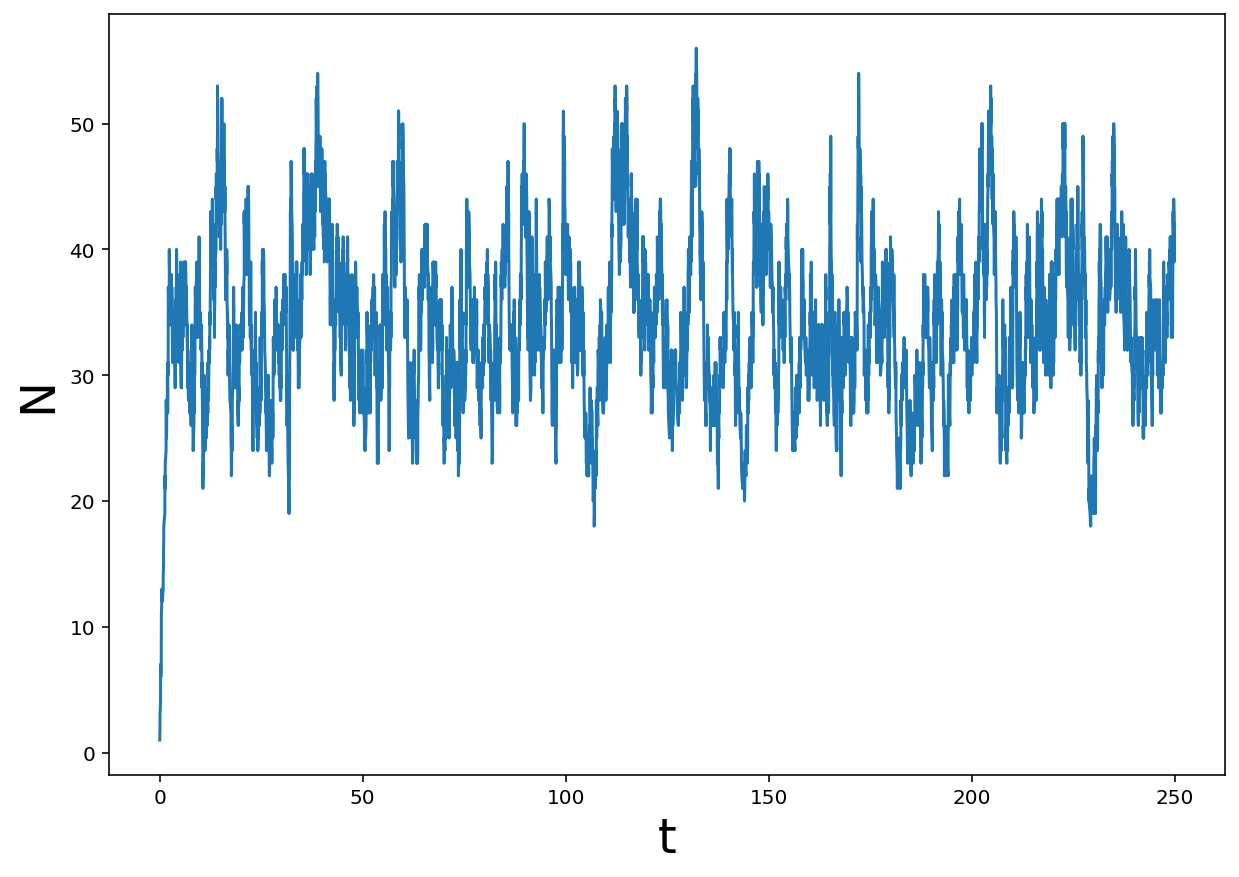

In [69]:
epsilon = 0.1
gamma = 1
lamda = 1
delta = 1
alpha = 1
beta = 100
s0 = 0
n0 = 1
Nsteps = 10000
def stochastic_pp(alpha, beta, gamma, lamda, epsilon, s0, n0, Nsteps):
    N = zeros(Nsteps)
    N[0] = n0
    S = zeros(Nsteps)
    S[0] = s0
    T = zeros(Nsteps)
    T[0] = 0
    for j in arange(1, Nsteps):
        s = S[j-1]
        n = N[j-1]
        if s == 0:
            rate = alpha/epsilon
        if s == 1:
            rate = beta/epsilon

        combined_rate = rate + (gamma*s + lamda*(1-s)) + (epsilon*delta*(n**1.5))
        u = rand(1)
        tau = -log(u)/combined_rate
        T[j] = T[j-1] + tau
        probability_vector = array([rate, (gamma*s + lamda*(1-s)), (epsilon*delta*(n**1.5))])/combined_rate
        cummulative_probability_vector = cumsum(probability_vector)
        u2 = rand(1)
        if u2 < cummulative_probability_vector[0]:
            if s == 0:
                S[j] = 1
            else:
                S[j] = 0
        if u2 < cummulative_probability_vector[1]:
            N[j] = N[j-1] + 1
        else:
            N[j] = N[j-1] - 1
            
    return T, S, N

figure(1, [10, 7])

###### Stochastic and ODE trajectories
T, S, N = stochastic_pp(alpha, beta, gamma, lamda, epsilon, s0, n0, Nsteps)

plot(T, N)


xlabel('t', fontsize=24)
ylabel('N', fontsize=24);

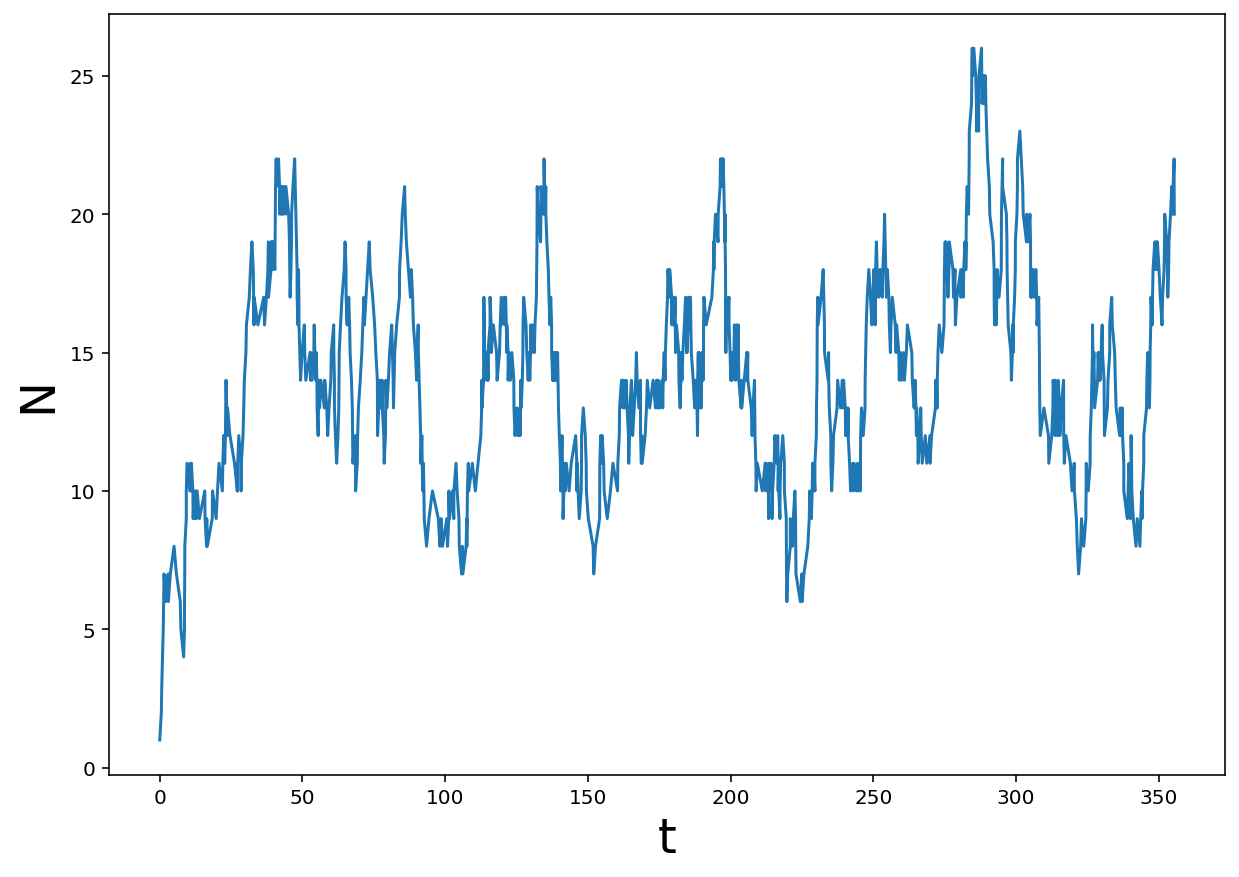

In [74]:
epsilon = 0.1
gamma = 2
lamda = 1
delta = 1
alpha = 1
beta = 1
s0 = 0
n0 = 1
Nsteps = 1000
def stochastic_pp_nomarkov(alpha, beta, gamma, lamda, epsilon, n0, Nsteps):
    N = zeros(Nsteps)
    N[0] = n0
    T = zeros(Nsteps)
    T[0] = 0
    s = alpha/(alpha+beta)
    for j in arange(1, Nsteps):
        n = N[j-1]
        combined_rate = (gamma*s + lamda*(1-s)) + (epsilon*delta*(n))
        u = rand(1)
        tau = -log(u)/combined_rate
        T[j] = T[j-1] + tau
        probability_vector = array([(gamma*s + lamda*(1-s)), (epsilon*delta*(n))])/combined_rate
        cummulative_probability_vector = cumsum(probability_vector)
        u2 = rand(1)
        if u2 < cummulative_probability_vector[0]:
            N[j] = N[j-1] + 1
        else:
            N[j] = N[j-1] - 1
            
    return T, N

figure(1, [10, 7])

###### Stochastic and ODE trajectories
T,N = stochastic_pp_nomarkov(alpha, beta, gamma, lamda, epsilon, n0, Nsteps)

plot(T, N)


xlabel('t', fontsize=24)
ylabel('N', fontsize=24);


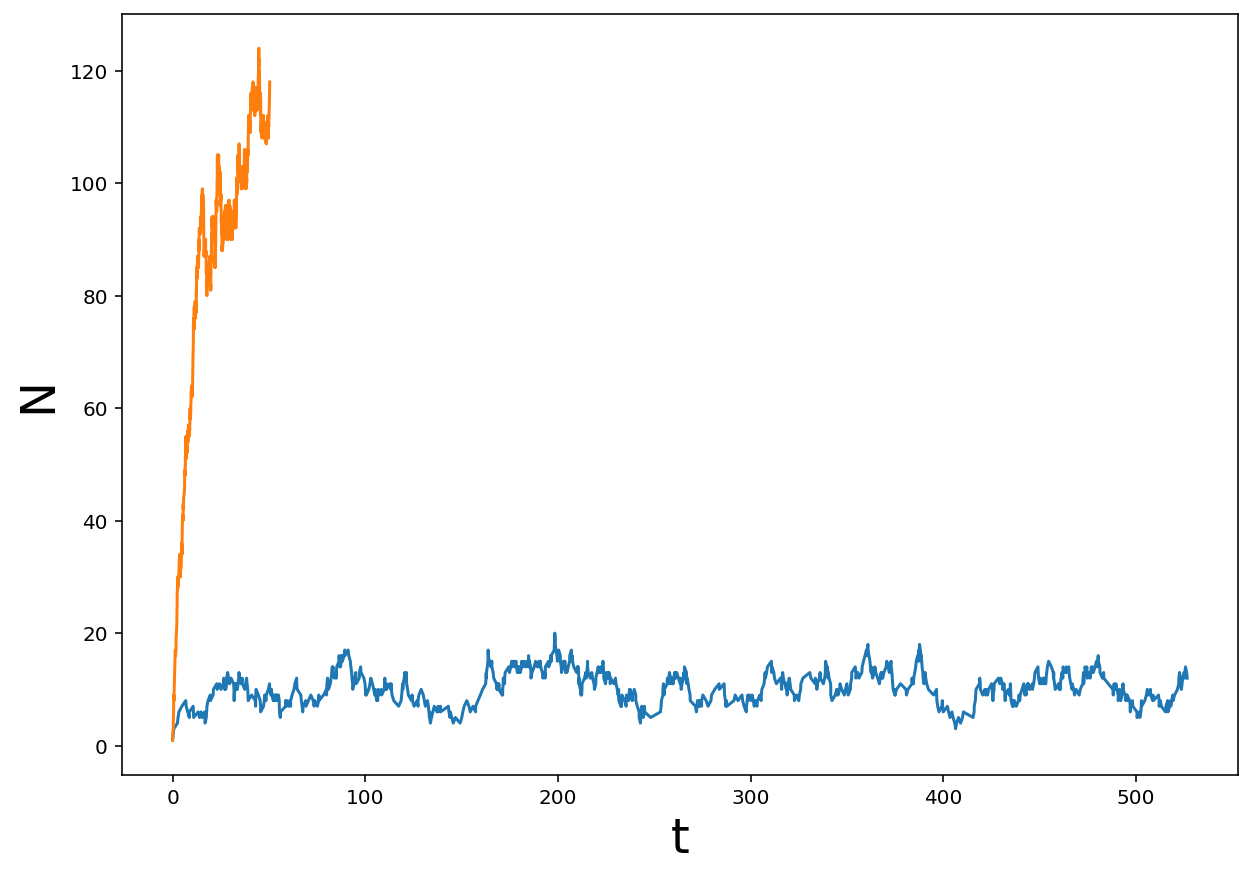

In [6]:
T,N = stochastic_pp_nomarkov(alpha, beta, gamma, lamda, epsilon, n0, Nsteps)
T2, S, N2 = stochastic_pp(alpha, beta, gamma, lamda, epsilon, s0, n0, Nsteps)

figure(1, [10, 7])

plot(T, N)
plot(T2, N2)
xlabel('t', fontsize=24)
ylabel('N', fontsize=24);
#hai ana uwu

(0, 75)

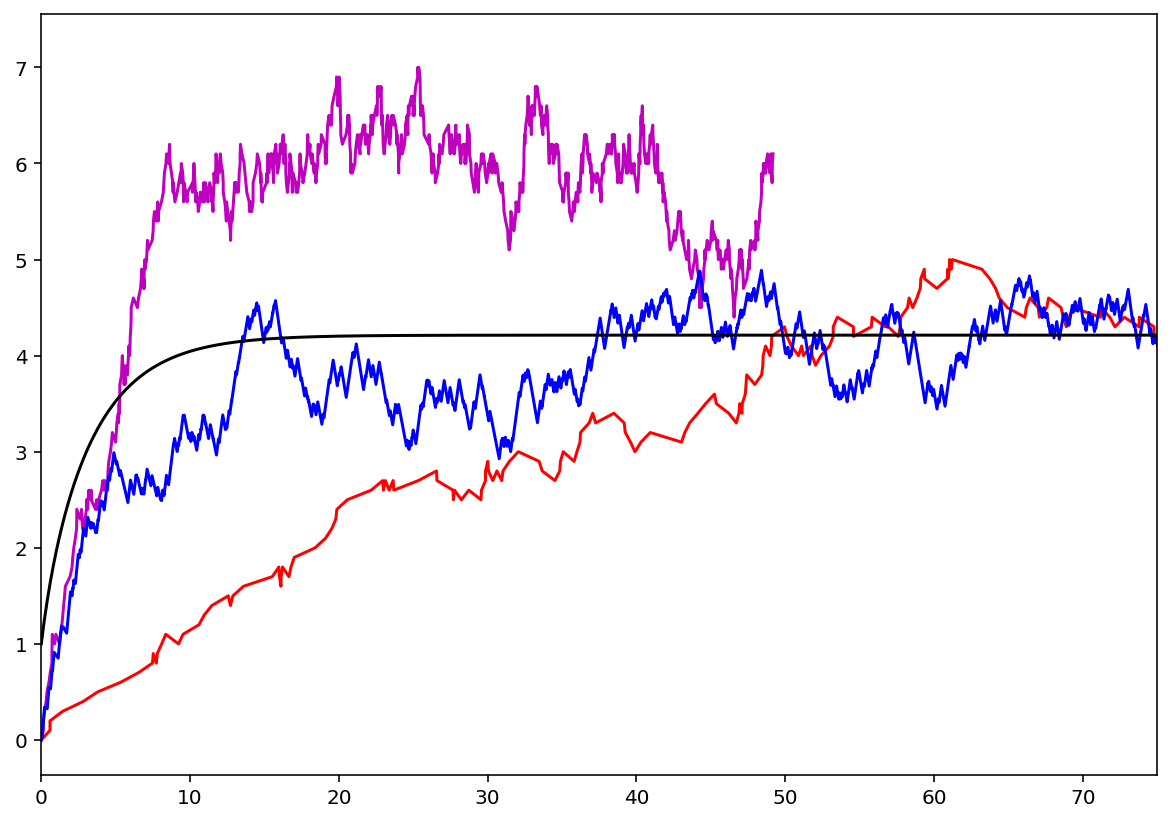

In [75]:
epsilon = 0.1
gamma = 2.
lamda = 1
delta = 0.25
alpha = 1.
beta = 1.
n0 = 0
s0 = 1
Delta_t = 0.1
Nsteps = 1000
x = zeros(Nsteps) 
x[0] = x0 


T1, S1, N1 = stochastic_pp(alpha, beta, gamma, lamda, epsilon, s0, n0, Nsteps)

T2,N2 = stochastic_pp_nomarkov(alpha, beta, gamma, lamda, epsilon, n0, Nsteps)

T3,S3,N3 = fullycoupledhybrid(alpha, beta, gamma, lamda, epsilon, s0, n0, Nsteps)

for n in arange(1, Nsteps): 
    x[n] = x[n-1] + Delta_t*f_gene(x[n-1])
T4 = Delta_t*arange(Nsteps) 
figure(1, [10, 7]) 
plot(T1,(epsilon)*N1, 'm')
plot(T2,epsilon*N2, 'r')
plot(T3,N3,'b')
plot(T4,x, 'k')
xlim([0,75])